# Импорт библиотек

In [5]:
!pip install pubchempy
!pip install rdkit
# Загружаем библиотеки
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import pubchempy as pcp

from rdkit import Chem
from rdkit.Chem import Descriptors

# Для корректного отображения графиков
%matplotlib inline

# Работа с датасетом

#### Объявляем функции

In [12]:
# Чистка датасета: удаляем дубликаты, фильтруем по двухкомп. системам (так как трёхкомпонентных мало и у них не указан тип DES) и
# по плотности < 2, убираем ненужные столбцы
def dataset_clear(dataset):
    dataset = dataset.drop_duplicates(subset=['Component#1', 'Component#2', 
                                    'X#1 (molar fraction)', 'X#2 (molar fraction)', 
                                    'Temperature, K', 'Density, g/cm^3'])
    dataset = dataset[(dataset['Number of components'] == 2) & (dataset['Density, g/cm^3'] <= 2.0)]
    dataset = dataset.drop(['Number of components', 'Reference (DOI)', 'X#3 (molar fraction)', 'Component#3', 'II'], axis=1)
    return dataset
    

In [13]:
# Группируем строки с одинаковыми значениями компонентов, молярных соотн., температуры, типа и усредняем плотности
def density_mean(dataset):
    dataset = dataset.groupby(['Type of DES', 'Component#1', 'Component#2', 
                           'X#1 (molar fraction)', 'X#2 (molar fraction)', 
                           'Temperature, K'], as_index = False).agg({'Density, g/cm^3':'mean', 'I':'min', 
                                                                     'III':'min', 'IV':'min', 'V':'min'})
    return dataset
    

In [14]:
# Выгружаем SMILES из PubChem и добавляем их в датасет
def get_smiles(dataset):

    replace_mapper = {'Octyl Paraben': 'octylparaben'} #Некорректное название, поменяем на правильное
    dataset.replace(replace_mapper, inplace=True)

    # Создаём список уникальных названий молекул
    dataset_unique_1 = list(dataset['Component#1'].unique())
    dataset_unique_2 = list(dataset['Component#2'].unique())
    dataset_unique_1.extend(dataset_unique_2)
    dataset_unique = list(set(dataset_unique_1))

    smiles_dict = {}

    for compound in dataset_unique:
        compounds = pcp.get_compounds(compound, 'name')
        
        # Делаем проверку, что соединение есть в базе
        try:
            mol = compounds[0]
            smiles_dict[compound] = mol.canonical_smiles
        except:
            print(f'Соединение c названием {compound} не найдено.')

    dataset['SMILES#1'] = dataset['Component#1'].map(smiles_dict)
    dataset['SMILES#2'] = dataset['Component#2'].map(smiles_dict)
    
    return dataset

In [15]:
# Добавляем дескрипторы из RDKit
def get_descriptors_values(descriptors_list, dataset):
    
    # Создаём лист уникальных SMILES
    smiles_unique_1 = list(dataset['SMILES#1'].unique())
    smiles_unique_2 = list(dataset['SMILES#2'].unique())
    smiles_unique_1.extend(smiles_unique_2)
    smiles_unique = list(set(smiles_unique_1))

    descriptors_dict = {}

    for smiles in smiles_unique:
        # Тест, что для SMILES доступны дескрипторы rdkit
        try:
            molecule = Chem.MolFromSmiles(smiles)
            descriptors_dict[smiles] = [Descriptors.CalcMolDescriptors(molecule)[descriptor] for descriptor in descriptors_list]
        except:
            print(f'Соединение cо SMILES {smiles} не найдено.')

    # Получаем словарь SMILES: [descriptor1, descriptor2, ...]
    return descriptors_dict

In [16]:
# Добавляем дескрипторы rdkit в датасет
def merge_descriptors(descriptors_dict, descriptors_list, dataset):
    
    # Создаём названия для столбцов
    column_list_1 = [i + '#1' for i in descriptors_list]
    column_list_2 = [i + '#2' for i in descriptors_list]

    for i in range(len(descriptors_list)):
        dataset[column_list_1[i]] = dataset['SMILES#1'].map(lambda x: descriptors_dict.get(x)[i])

    for i in range(len(descriptors_list)):
        dataset[column_list_2[i]] = dataset['SMILES#2'].map(lambda x: descriptors_dict.get(x)[i])
        
    return dataset

#### Подготовка датасета

In [20]:
dataset = pd.read_csv(r'C:\Users\elf_z\Ecoteam-main\files\Density.csv')
dataset.head(5)

,Number of components,Type of DES,I,II,III,IV,V,Component#1,Component#2,Component#3,X#1 (molar fraction),X#2 (molar fraction),X#3 (molar fraction),"Temperature, K","Density, g/cm^3",Reference (DOI)
0,2,Ⅰ,1,0,0,0,0,Zincchloride,1-Butyl-3-methyl imidazolium chloride,NaN,0.500,0.500,NaN,300.20,1.10250,10.1016/j.cclet.2013.09.004
1,2,Ⅰ,1,0,0,0,0,Zincchloride,1-Butyl-3-methylimidazolium chloride,NaN,0.500,0.500,NaN,303.15,1.50913,10.1016/j.jobe.2021.103056
2,2,Ⅰ,1,0,0,0,0,Zincchloride,1-Butyl-3-methylimidazolium chloride,NaN,0.333,0.667,NaN,303.15,1.34292,10.1016/j.jobe.2021.103056
3,2,Ⅰ,1,0,0,0,0,Iron(3+) Trichloride,Tetrabutylphosphonium bromide,NaN,0.333,0.667,NaN,293.00,1.19500,10.1016/j.cep.2015.04.001
4,2,Ⅰ,1,0,0,0,0,Iron(3+) Trichloride,Tetrabutylphosphonium bromide,NaN,0.333,0.667,NaN,303.00,1.18800,10.1016/j.cep.2015.04.001


In [21]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4309 entries, 0 to 4308
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Number of components  4309 non-null   int64  
 1   Type of DES           3984 non-null   object 
 2   I                     4309 non-null   int64  
 3   II                    4309 non-null   int64  
 4   III                   4309 non-null   int64  
 5   IV                    4309 non-null   int64  
 6   V                     4309 non-null   int64  
 7   Component#1           4309 non-null   object 
 8   Component#2           4309 non-null   object 
 9   Component#3           325 non-null    object 
 10  X#1 (molar fraction)  4309 non-null   float64
 11  X#2 (molar fraction)  4309 non-null   float64
 12  X#3 (molar fraction)  325 non-null    float64
 13  Temperature, K        4309 non-null   float64
 14  Density, g/cm^3       4309 non-null   float64
 15  Reference (DOI)      

In [22]:
dataset.describe()

,Number of components,I,II,III,IV,V,X#1 (molar fraction),X#2 (molar fraction),X#3 (molar fraction),"Temperature, K","Density, g/cm^3"
count,4309.000000,4309.000000,4309.000000,4309.000000,4309.000000,4309.000000,4309.000000,4309.000000,325.000000,4309.000000,4309.000000
mean,2.075424,0.013692,0.000464,0.655372,0.071942,0.337897,0.340917,0.641705,0.224315,320.035424,42.854478
std,0.264104,0.116224,0.021542,0.475302,0.258423,0.473048,0.190665,0.197232,0.262686,20.757705,1201.130102
min,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.034000,0.078000,0.016393,278.150000,0.806000
25%,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.500000,0.041683,303.150000,1.000612
50%,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.333000,0.667000,0.062500,318.150000,1.090300
75%,2.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.500000,0.800000,0.333333,333.150000,1.185486
max,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.917000,0.950000,0.843000,413.150000,44562.000000


In [23]:
# Чистим датасет и усредняем плотности
pre_dataset = dataset_clear(dataset)
pre_dataset = density_mean(pre_dataset)

In [24]:
# SMILES
pre_dataset = get_smiles(pre_dataset)

In [25]:
# Объявляем дескрипторы из rdkit, добавляем их в датасет
descriptors_list = ['MolLogP', 'NumHeteroatoms', 'NumAromaticRings', 'NumHAcceptors', 'NumHDonors', 'NumRotatableBonds', 'TPSA', 'MolWt']

descriptors_dict = get_descriptors_values(descriptors_list, pre_dataset)
final_dataset = merge_descriptors(descriptors_dict, descriptors_list, pre_dataset)
final_dataset.head(5)


,Type of DES,Component#1,Component#2,X#1 (molar fraction),X#2 (molar fraction),"Temperature, K","Density, g/cm^3",I,III,IV,...,TPSA#1,MolWt#1,MolLogP#2,NumHeteroatoms#2,NumAromaticRings#2,NumHAcceptors#2,NumHDonors#2,NumRotatableBonds#2,TPSA#2,MolWt#2
0,Ⅰ,Aluminium Chloride Anhydrous,"N-benzyl-N,N-dibutylbutan-1-aminium chloride",0.667,0.333,298.0,1.0007,1,0,0,...,0.0,133.341,2.4077,2,1,0,0,11,0.0,311.941
1,Ⅰ,Cuprymina,"N-benzyl-N,N-dibutylbutan-1-aminium chloride",0.667,0.333,298.0,1.0039,1,0,0,...,0.0,134.452,2.4077,2,1,0,0,11,0.0,311.941
2,Ⅰ,Iron(3+) Trichloride,Cetyltrimethylammonium bromide,0.500,0.500,298.0,1.1900,1,0,0,...,0.0,162.204,3.1779,2,0,0,0,15,0.0,364.456
3,Ⅰ,Iron(3+) Trichloride,Dodecyltrimethylammonium bromide,0.500,0.500,298.0,1.2700,1,0,0,...,0.0,162.204,1.6175,2,0,0,0,11,0.0,308.348
4,Ⅰ,Iron(3+) Trichloride,"N-benzyl-N,N-dibutylbutan-1-aminium chloride",0.667,0.333,298.0,1.0001,1,0,0,...,0.0,162.204,2.4077,2,1,0,0,11,0.0,311.941


In [26]:
final_dataset.describe()

,X#1 (molar fraction),X#2 (molar fraction),"Temperature, K","Density, g/cm^3",I,III,IV,V,MolLogP#1,NumHeteroatoms#1,...,TPSA#1,MolWt#1,MolLogP#2,NumHeteroatoms#2,NumAromaticRings#2,NumHAcceptors#2,NumHDonors#2,NumRotatableBonds#2,TPSA#2,MolWt#2
count,3787.000000,3787.000000,3787.000000,3787.000000,3787.000000,3787.000000,3787.000000,3787.000000,3787.000000,3787.000000,...,3787.000000,3787.000000,3787.000000,3787.000000,3787.000000,3787.000000,3787.000000,3787.000000,3787.000000,3787.000000
mean,0.351808,0.647673,320.336084,1.081509,0.006866,0.648006,0.043306,0.301822,-0.752648,2.658833,...,21.653929,186.691311,0.567951,2.472934,0.220755,1.837338,1.676789,3.064695,46.130317,120.041627
std,0.193485,0.194623,20.938873,0.139277,0.082585,0.477655,0.203572,0.459109,3.488063,1.050396,...,20.055483,88.996349,1.936625,1.174880,0.440743,1.063464,0.895842,3.481562,21.347503,52.084971
min,0.050000,0.083000,278.150000,0.806000,0.000000,0.000000,0.000000,0.000000,-12.364800,1.000000,...,0.000000,68.079000,-5.395600,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,46.025000
25%,0.200000,0.500000,303.150000,0.983050,0.000000,0.000000,0.000000,0.000000,-3.311100,2.000000,...,17.070000,139.626000,-1.029000,2.000000,0.000000,1.000000,1.000000,1.000000,37.300000,90.078000
50%,0.333000,0.667000,318.150000,1.071200,0.000000,1.000000,0.000000,0.000000,-0.970300,3.000000,...,20.230000,139.626000,-0.118300,2.000000,0.000000,2.000000,1.000000,2.000000,40.460000,108.140000
75%,0.500000,0.800000,333.150000,1.171350,0.000000,1.000000,0.000000,1.000000,2.007600,3.000000,...,20.230000,210.159000,1.700620,3.000000,0.000000,2.000000,2.000000,4.000000,57.530000,150.174000
max,0.917000,0.950000,413.150000,1.592100,1.000000,1.000000,1.000000,1.000000,9.431000,8.000000,...,132.130000,546.807000,6.332500,11.000000,2.000000,11.000000,8.000000,17.000000,189.530000,392.510000


In [27]:
final_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3787 entries, 0 to 3786
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Type of DES           3787 non-null   object 
 1   Component#1           3787 non-null   object 
 2   Component#2           3787 non-null   object 
 3   X#1 (molar fraction)  3787 non-null   float64
 4   X#2 (molar fraction)  3787 non-null   float64
 5   Temperature, K        3787 non-null   float64
 6   Density, g/cm^3       3787 non-null   float64
 7   I                     3787 non-null   int64  
 8   III                   3787 non-null   int64  
 9   IV                    3787 non-null   int64  
 10  V                     3787 non-null   int64  
 11  SMILES#1              3787 non-null   object 
 12  SMILES#2              3787 non-null   object 
 13  MolLogP#1             3787 non-null   float64
 14  NumHeteroatoms#1      3787 non-null   int64  
 15  NumAromaticRings#1   

In [30]:
# Сохраняем финальный датасет
final_dataset.to_csv(r'C:\Users\elf_z\Ecoteam-main\files\Final.csv')

In [32]:
df = pd.read_csv(r'C:\Users\elf_z\Ecoteam-main\files\Final.csv')
df.drop(['Unnamed: 0', ], axis=1, inplace=True)

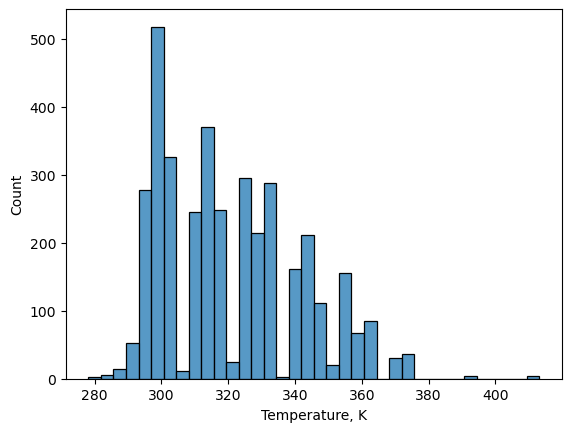

In [33]:
plot1 = sns.histplot(data=df, x='Temperature, K')

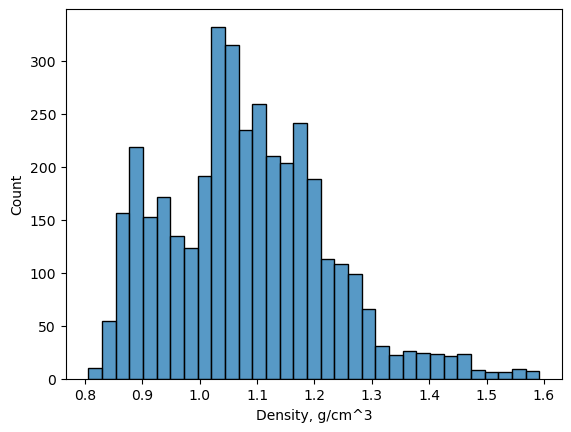

In [34]:
plot2 = sns.histplot(data=df, x='Density, g/cm^3')